# Active-learning example with MNIST data for digit recognition

The goal of this notebook is to show how a simple active-learning campaign can be designed for digit recognition using CAMD.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.datasets import fetch_openml
from camd.agent.base import RandomAgent, HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.experiment import ATFSampler
from camd.loop import Loop
from scipy.stats import entropy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
path = os.getcwd()

Let's fetch the MNIST dataset by LeCun et al. from OpenML

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
df = pd.DataFrame(X)

Dataset has 70,000 labeled instances of hand written digits in 28x28 resolution. We'll use 10,000 for testing our active-learning model. Use 60000 for active-learning itself.

In [3]:
print(df.shape)

(70000, 784)


This is what a typical example looks like:

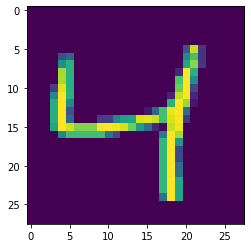

In [4]:
plt.imshow(X[2].reshape(28,28))

Let's prepare our data for camd.Loop

In [5]:
df.index = [str(i) for i in list(df.index)] # indices need to be strings
y = y.astype(int)  # we need target as int
df['target'] = y   # and target needs to be part of df
test_df = df.sample(10000, random_state=42) # setting aside 10,000 examples for testing
df = df.drop(test_df.index, axis=0)
print(df.shape)

(60000, 785)


Now let's construct an Agent that tries to choose the next set of examples to be labeled by a human oracle (which corresponds to the Experiment class in camd). Note we have 10 digits (hence classes), this for each example we get 10 probability estimations for belonging to digit classes

Our Agents strategy is to pick the examples where the class assignments are the most undecided, which we quantify by calculating the entropy of the predicted probabilities from 0 to 9. The larger the entropy, the closer the point is to the ``decision boundaries`` of the classifier.

Given the seed data and candidate data, our Agent will simply return a list of N_query number of examples to send for labeling.

In [6]:
class DecisionBoundary(HypothesisAgent):
    def __init__(self, candidate_data=None, seed_data=None, N_query=None, clf=None, clf_params=None):
        self.candidate_data = candidate_data
        self.seed_data = seed_data
        self.N_query = N_query if N_query else 1
        self.cv_score = np.nan
        self.clf = clf(**clf_params)
        super(DecisionBoundary).__init__()
        
    def get_hypotheses(self, candidate_data, seed_data=None):
        self.candidate_data = candidate_data.drop(columns=['target'], axis=1)
        self.seed_data = seed_data
        X_train = seed_data.drop(columns=['target'], axis=1)
        y_train = seed_data['target']
        
        # CV score from acquired data
        cv_score = cross_val_score(self.clf, X_train, y_train,
                                   cv=KFold(3, shuffle=True))
        self.cv_score = np.mean(cv_score)
        
        # Fit the main model, make predictions and request new experiments based on entorpy
        self.clf.fit(X_train, y_train)
        probabs = self.clf.predict_proba(self.candidate_data)
        self.probabs = probabs
        neg_entropies = [-1*entropy(probabs[i]) for i in range(len(probabs))]
        selected = np.argsort(neg_entropies)[:self.N_query]
        selected = candidate_data.index.values[selected].tolist()
        return selected

We design an `Analyzer` to test the active-learning model against the independent test set and stores the scores. It trains a classifier with acquired data, and evaluates the performance on test data. Note some arguments in the analyzer below are not used and are there for the `Loop` not to break when it tries to pass such arguments to `MnistAnalyze`.

In [7]:
class MnistAnalyze(AnalyzerBase):
    def __init__(self, test_df, clf, clf_params, *args, **kwargs):
        self.score = []
        self.test_df = test_df
        self.clf = clf
        self.clf_params = clf_params
        super(MnistAnalyze, self).__init__()
    def analyze(self, df, submitted_experiment_request, consumed):
        X = df.drop(columns=['target'], axis=1)
        y = df['target']
        clf = self.clf(**clf_params)
        clf.fit(X, y)
        self.score.append(clf.score(test_df.drop('target', axis=1), test_df['target']))
        print('score', self.score)
        return [], []
    def present(self, a, b, c, *args, **kwargs):
        pass

We will now setup our active learning campaign simulation by specifying the hyperparameters of the loop, such as the maximum number of queries allowed in each iteration, number of examples to pick as the seed, `Agent`, `Analyzer` and `Experiment` classes (and their parameters) to be used. Here we are using the `ATFSampler` class as the experiment, which helps perform an after-the-fact simulation by simply looking up the results from the provided dataframe. 

In [8]:
N_query = 500  # This many new examples are asked to oracle in each iteration (labeled by humans in reality)
N_seed = 5000  # This many samples are randomly acquired in the beginning to form a seed.
clf = LogisticRegression
clf_params = {'C': 50./X.shape[1], 'multi_class':'multinomial', 'penalty':'l1', 'solver':'saga', 'tol':0.1}
agent = DecisionBoundary
agent_params = {'N_query': N_query, 'clf':clf, 'clf_params': clf_params}
analyzer = MnistAnalyze
analyzer_params = {'test_df': test_df, 'clf':clf, 'clf_params': clf_params}
experiment = ATFSampler
experiment_params = {'dataframe': df}
candidate_data = df

Let's construct a `Loop`, which will execute the entire campaign. You should make a folder named 'mnist-entropy' in the working directory of this notebook.

In [9]:
new_loop = Loop(candidate_data, agent, experiment, analyzer,
               agent_params=agent_params, analyzer_params=analyzer_params, 
               experiment_params=experiment_params,path=os.path.join(path, 'mnist-entropy'),create_seed=N_seed)

Initialize the loop to create an initial seed with N_seed examples randomly picked from the candidate data. It actually runs the RandomAgent under the hood.

In [10]:
new_loop.initialize()

Loop initialization state: Agent RandomAgent hypothesizing
Loop 0 state: Running experiments


Now our loop is initialized, and a set of new "experiments" are submitted. We will ask the Loop to start runing with 10 iterations:

In [11]:
new_loop.auto_loop(n_iterations=30, timeout=0)

Iteration: 0
Loop 0 state: Getting new results
Loop 0 state: Analyzing results
score [0.8962]
Loop 0 state: Agent DecisionBoundary hypothesizing
Loop 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Loop 1 state: Getting new results
Loop 1 state: Analyzing results
score [0.8962, 0.9003]
Loop 1 state: Agent DecisionBoundary hypothesizing
Loop 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Loop 2 state: Getting new results
Loop 2 state: Analyzing results
score [0.8962, 0.9003, 0.9015]
Loop 2 state: Agent DecisionBoundary hypothesizing
Loop 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Loop 3 state: Getting new results
Loop 3 state: Analyzing results
score [0.8962, 0.9003, 0.9015, 0.9018]
Loop 3 state: Agent DecisionBoundary hypothesizing
Loop 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Loop 4 state: Getting new results
Loop 4 state: Analyzing results
score [0.8962, 0.9003, 0.9015, 0.9018, 0.

Loop 26 state: Running experiments
  Waiting for next round ...
Iteration: 27
Loop 27 state: Getting new results
Loop 27 state: Analyzing results
score [0.8962, 0.9003, 0.9015, 0.9018, 0.9028, 0.9001, 0.9036, 0.9028, 0.9049, 0.9068, 0.9062, 0.9087, 0.9094, 0.9096, 0.9103, 0.9117, 0.9139, 0.9151, 0.9156, 0.9181, 0.918, 0.9195, 0.9203, 0.9208, 0.9196, 0.92, 0.9207, 0.9198]
Loop 27 state: Agent DecisionBoundary hypothesizing
Loop 27 state: Running experiments
  Waiting for next round ...
Iteration: 28
Loop 28 state: Getting new results
Loop 28 state: Analyzing results
score [0.8962, 0.9003, 0.9015, 0.9018, 0.9028, 0.9001, 0.9036, 0.9028, 0.9049, 0.9068, 0.9062, 0.9087, 0.9094, 0.9096, 0.9103, 0.9117, 0.9139, 0.9151, 0.9156, 0.9181, 0.918, 0.9195, 0.9203, 0.9208, 0.9196, 0.92, 0.9207, 0.9198, 0.9198]
Loop 28 state: Agent DecisionBoundary hypothesizing
Loop 28 state: Running experiments
  Waiting for next round ...
Iteration: 29
Loop 29 state: Getting new results
Loop 29 state: Analyzing re

Text(0.5, 0, 'iteration')

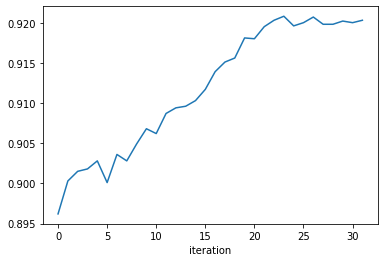

In [12]:
plt.plot(new_loop.analyzer.score)
plt.xlabel('iteration')

### Next: Simulations, confidence intervals and baselines

How confident are we with this simulation? In the next step, we will run multiple versions of this simulation with different seeds to build a confidence bound around our learning curve. In addition, we will simulate a strong baseline to compare: i.e. random acquisition. Random acquisition is not easy when the goal is to improve prediction accuracy at minimal acquisition cost. 

We parallelize this a little bit.

In [13]:
from joblib import Parallel, delayed

In [14]:
def entropy_campaign(i):
    loop_dir = os.path.join(path,'mnist-entropy-{}'.format(i))
    os.mkdir(loop_dir)
    loop = Loop(candidate_data, agent, experiment, analyzer,
                agent_params=agent_params, analyzer_params=analyzer_params, 
                experiment_params=experiment_params,path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=np.random.randint(0,100000))
    loop.auto_loop(n_iterations=30, timeout=0)
    return loop

In [15]:
entropy_results = Parallel(n_jobs=-1)(delayed(entropy_campaign)(i) for i in range(8))

Let's also run similar simulations with a randomly aquiring agent: `RandomAgent`

In [16]:
agent_random = RandomAgent
agent_random_params = {'N_query': N_query}

In [17]:
def random_campaign(i):
    loop_dir = os.path.join(path,'mnist-random-{}'.format(i))
    os.mkdir(loop_dir)
    loop = Loop(candidate_data, agent_random, experiment, analyzer,
                agent_params=agent_random_params, analyzer_params=analyzer_params, 
                experiment_params=experiment_params,path=loop_dir,create_seed=N_seed)
    loop.initialize(random_state=np.random.randint(0,100000))
    loop.auto_loop(n_iterations=30, timeout=0)
    return loop

In [18]:
random_results = Parallel(n_jobs=-1)(delayed(random_campaign)(i) for i in range(8))

Putting our results together.

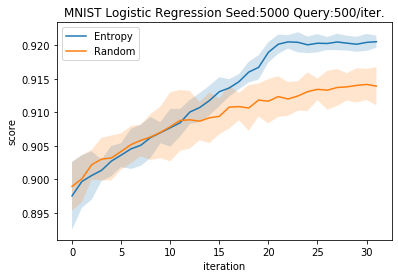

In [19]:
merged1 = np.array([i.analyzer.score for i in entropy_results])
merged2 = np.array([i.analyzer.score for i in random_results])
mu1 = np.mean(merged1, axis=0)
mu2 = np.mean(merged2, axis=0)
std1 = np.std(merged1, axis=0)
std2 = np.std(merged2, axis=0)

plt.fill_between(range(len(mu1)), mu1+2*std1, mu1-2*std1, alpha=0.2)
plt.plot(mu1, label='Entropy')
plt.fill_between(range(len(mu2)), mu2+2*std2, mu2-2*std2, alpha=0.2)
plt.plot(mu2, label='Random')
plt.title('MNIST Logistic Regression Seed:5000 Query:500/iter.')
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()

We find that the accuracy of a Logistic Regression classifier for MNIST data can be improved more quickly with active-learning via entropy-based acquisition, compared to random acquisition of new labels.